<img src="LEGO_logo.png" alt="WHI" width="300"/>

#### Import libraries

In [3724]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import yfinance as yf
import statsmodels.api as sm
from pandas_datareader import data as pdr

#### Paths and data

In [3725]:
# Paths for easier management
csv_path = Path() / "csv"
plots_path = Path() / "plots"

#### Data cleaning

In [3726]:
# Read all csv files
df = pd.read_csv(csv_path / 'lego_to_be_cleaned.csv', )
timeseries = pd.read_csv(csv_path / 'time_series.csv', sep=";")
liquidity = pd.read_csv(csv_path /'liquidity.csv', sep=";") 

In [3727]:
df.head(2)

,Number,Name,Theme,Subtheme,Year,Pieces,Minifigs,Availability,Retired,ReleasedDate,...,Retail,Paid,Value,Growth,Condition,Date,Notes,Collection,Status,URL
0,75144-1,Snowspeeder,Star Wars,Ultimate Collector Series,2017,1703,2,Exclusive,True,05/05/2017,...,199;99 €,199;99 €,330;40 €,65.21,New,NaN,NaN,Default,Owned,https://www.brickeconomy.com/set/75144-1/lego-...
1,10251-1,Brick Bank,Icons,Modular Buildings,2016,2380,6,RetailLimited,True,02/01/2016,...,149;99 €,149;99 €,494;81 €,229.89,New,NaN,NaN,Default,Owned,https://www.brickeconomy.com/set/10251-1/lego-...


In [3728]:
# Delete all not wanted columns
df = df.drop(['Subtheme', 'Paid', 'Growth', 'Condition', 'Date', 'Notes', 'Collection', 'Status', 'URL'], axis='columns')

In [3729]:
# All column names should start with a lowerletter and have '_' where space is required
df.columns = [col.lower() for col in df.columns]
df.rename(columns={'releaseddate': 'released_date'}, inplace=True)
df.rename(columns={'retireddate': 'retired_date'}, inplace=True)

df.head()

,number,name,theme,year,pieces,minifigs,availability,retired,released_date,retired_date,retail,value
0,75144-1,Snowspeeder,Star Wars,2017,1703,2,Exclusive,True,05/05/2017,15/01/2019,199;99 €,330;40 €
1,10251-1,Brick Bank,Icons,2016,2380,6,RetailLimited,True,02/01/2016,14/11/2018,149;99 €,494;81 €
2,10252-1,Volkswagen Beetle,Icons,2016,1167,0,Exclusive,True,01/08/2016,03/12/2020,89;99 €,113;14 €
3,10253-1,Big Ben,Icons,2016,4163,0,Exclusive,True,02/07/2016,25/11/2018,219;99 €,327;12 €
4,10702-1,Creative Building Set,Classic,2016,583,0,Retail,True,02/01/2016,24/11/2017,24;99 €,30;14 €


In [3730]:
# Checking for ‘NaN’ - empty cells in columns
print(df.isnull().sum())

# Counting the number of rows with missing values
num_rows_with_nan = df[df.isnull().any(axis=1)].shape[0]
print(f'Number of rows with at least one NaN value: {num_rows_with_nan}.')

number            0
name              1
theme             0
year              0
pieces            0
minifigs          0
availability      0
retired           0
released_date    19
retired_date     15
retail            0
value             0
dtype: int64
Number of rows with at least one NaN value: 35.


In [3731]:
# Removing rows with at least one NaN value
df = df.dropna()
print(df.isnull().sum())

number           0
name             0
theme            0
year             0
pieces           0
minifigs         0
availability     0
retired          0
released_date    0
retired_date     0
retail           0
value            0
dtype: int64


In [3732]:
# Function to clean and convert currency values
def clean_currency(value):
    try:
        # Remove the currency symbol and replace ';' with '.'
        value = value.replace('€', '').replace(';', '.').strip()
        # Convert to float
        return float(value)
    except ValueError:
        # Return None if conversion is not possible
        return None

# Apply the function to the 'retail' and 'value' columns
df['retail'] = df['retail'].apply(clean_currency)
df['value'] = df['value'].apply(clean_currency)

# Drop rows where conversion to float was not possible
df = df.dropna(subset=['retail', 'value']).reset_index(drop=True)

df.head()

,number,name,theme,year,pieces,minifigs,availability,retired,released_date,retired_date,retail,value
0,75144-1,Snowspeeder,Star Wars,2017,1703,2,Exclusive,True,05/05/2017,15/01/2019,199.99,330.40
1,10251-1,Brick Bank,Icons,2016,2380,6,RetailLimited,True,02/01/2016,14/11/2018,149.99,494.81
2,10252-1,Volkswagen Beetle,Icons,2016,1167,0,Exclusive,True,01/08/2016,03/12/2020,89.99,113.14
3,10253-1,Big Ben,Icons,2016,4163,0,Exclusive,True,02/07/2016,25/11/2018,219.99,327.12
4,10702-1,Creative Building Set,Classic,2016,583,0,Retail,True,02/01/2016,24/11/2017,24.99,30.14


In [3733]:
# Function to convert date format and handle invalid dates
def convert_date_format(date_str):
    try:
        return pd.to_datetime(date_str, format="%d/%m/%Y")
    except ValueError:
        return pd.NaT

# Apply the function to the date columns using .loc to avoid the SettingWithCopyWarning
df.loc[:, 'released_date'] = df['released_date'].apply(convert_date_format)
df.loc[:, 'retired_date'] = df['retired_date'].apply(convert_date_format)

# Remove rows with invalid dates
df = df.dropna(subset=['released_date', 'retired_date']).reset_index(drop=True)

df.head()

,number,name,theme,year,pieces,minifigs,availability,retired,released_date,retired_date,retail,value
0,75144-1,Snowspeeder,Star Wars,2017,1703,2,Exclusive,True,2017-05-05 00:00:00,2019-01-15 00:00:00,199.99,330.40
1,10251-1,Brick Bank,Icons,2016,2380,6,RetailLimited,True,2016-01-02 00:00:00,2018-11-14 00:00:00,149.99,494.81
2,10252-1,Volkswagen Beetle,Icons,2016,1167,0,Exclusive,True,2016-08-01 00:00:00,2020-12-03 00:00:00,89.99,113.14
3,10253-1,Big Ben,Icons,2016,4163,0,Exclusive,True,2016-07-02 00:00:00,2018-11-25 00:00:00,219.99,327.12
4,10702-1,Creative Building Set,Classic,2016,583,0,Retail,True,2016-01-02 00:00:00,2017-11-24 00:00:00,24.99,30.14


In [3734]:
# Checking for duplicates in the data
duplicates_num = df.duplicated().sum()

if duplicates_num == 0:
    print('There are no duplicates in the data.')
else:
    print(f'There are {duplicates_num} duplicates in the data.')
    duplicates = df[df.duplicated(keep=False)]
    print('Duplicates:')
    print(duplicates)
    
    # Removing duplicates
    df = df.drop_duplicates()
    print(f'Duplicates have been removed. The cleaned data now has {df.shape[0]} rows.')

There are 5 duplicates in the data.
Duplicates:
       number              name         theme  year  pieces  minifigs  \
8817   8748-1  Rhotuka Spinners      Bionicle  2005       5         0   
8818   8748-1  Rhotuka Spinners      Bionicle  2005       5         0   
11407   210-2   Small Store Set  System i Leg  1958      30         0   
11408   210-2   Small Store Set  System i Leg  1958      30         0   
11420   226-1     8 Named Beams  System i Leg  1958       8         0   
11421   226-1     8 Named Beams  System i Leg  1958       8         0   
11439   259-1    1:87 VW Pickup  System i Leg  1958       0         0   
11440   259-1    1:87 VW Pickup  System i Leg  1958       0         0   
11446   308-3      Fire Station  System i Leg  1958     111         0   
11447   308-3      Fire Station  System i Leg  1958     111         0   

      availability  retired        released_date         retired_date  retail  \
8817        Retail     True  2005-01-01 00:00:00  2007-01-01 00:00:

In [3735]:
# Checking for duplicates in the data
duplicates_num = df.duplicated().sum()
duplicates_num

0

In [3736]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17304 entries, 0 to 17308
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   number         17304 non-null  object 
 1   name           17304 non-null  object 
 2   theme          17304 non-null  object 
 3   year           17304 non-null  int64  
 4   pieces         17304 non-null  int64  
 5   minifigs       17304 non-null  int64  
 6   availability   17304 non-null  object 
 7   retired        17304 non-null  bool   
 8   released_date  17304 non-null  object 
 9   retired_date   17304 non-null  object 
 10  retail         17304 non-null  float64
 11  value          17304 non-null  float64
dtypes: bool(1), float64(2), int64(3), object(6)
memory usage: 1.6+ MB


In [3737]:
df.reset_index(drop=True)

,number,name,theme,year,pieces,minifigs,availability,retired,released_date,retired_date,retail,value
0,75144-1,Snowspeeder,Star Wars,2017,1703,2,Exclusive,True,2017-05-05 00:00:00,2019-01-15 00:00:00,199.99,330.40
1,10251-1,Brick Bank,Icons,2016,2380,6,RetailLimited,True,2016-01-02 00:00:00,2018-11-14 00:00:00,149.99,494.81
2,10252-1,Volkswagen Beetle,Icons,2016,1167,0,Exclusive,True,2016-08-01 00:00:00,2020-12-03 00:00:00,89.99,113.14
3,10253-1,Big Ben,Icons,2016,4163,0,Exclusive,True,2016-07-02 00:00:00,2018-11-25 00:00:00,219.99,327.12
4,10702-1,Creative Building Set,Classic,2016,583,0,Retail,True,2016-01-02 00:00:00,2017-11-24 00:00:00,24.99,30.14
...,...,...,...,...,...,...,...,...,...,...,...,...
17299,662403-1,Zombie with Burning Baby Zombie and TNT,Minecraft,2024,12,2,Promotional,True,2024-01-01 00:00:00,2024-02-01 00:00:00,0.00,4.73
17300,9790-1,ROBOLAB Team Challenge Set,Education,1999,725,0,Retail,True,1999-01-01 00:00:00,2001-01-01 00:00:00,175.99,193.78
17301,2000443-1,Workshop Kit Freewheeler,Education,2015,82,1,RetailLimited,True,2015-01-01 00:00:00,2017-01-01 00:00:00,8.79,11.00
17302,2000442-1,Workshop Kit Spinning Top,Education,2015,10,0,Retail,True,2015-01-01 00:00:00,2017-01-01 00:00:00,8.79,23.77


In [3738]:
df.to_csv(csv_path / 'lego.csv')
df

,number,name,theme,year,pieces,minifigs,availability,retired,released_date,retired_date,retail,value
0,75144-1,Snowspeeder,Star Wars,2017,1703,2,Exclusive,True,2017-05-05 00:00:00,2019-01-15 00:00:00,199.99,330.40
1,10251-1,Brick Bank,Icons,2016,2380,6,RetailLimited,True,2016-01-02 00:00:00,2018-11-14 00:00:00,149.99,494.81
2,10252-1,Volkswagen Beetle,Icons,2016,1167,0,Exclusive,True,2016-08-01 00:00:00,2020-12-03 00:00:00,89.99,113.14
3,10253-1,Big Ben,Icons,2016,4163,0,Exclusive,True,2016-07-02 00:00:00,2018-11-25 00:00:00,219.99,327.12
4,10702-1,Creative Building Set,Classic,2016,583,0,Retail,True,2016-01-02 00:00:00,2017-11-24 00:00:00,24.99,30.14
...,...,...,...,...,...,...,...,...,...,...,...,...
17304,662403-1,Zombie with Burning Baby Zombie and TNT,Minecraft,2024,12,2,Promotional,True,2024-01-01 00:00:00,2024-02-01 00:00:00,0.00,4.73
17305,9790-1,ROBOLAB Team Challenge Set,Education,1999,725,0,Retail,True,1999-01-01 00:00:00,2001-01-01 00:00:00,175.99,193.78
17306,2000443-1,Workshop Kit Freewheeler,Education,2015,82,1,RetailLimited,True,2015-01-01 00:00:00,2017-01-01 00:00:00,8.79,11.00
17307,2000442-1,Workshop Kit Spinning Top,Education,2015,10,0,Retail,True,2015-01-01 00:00:00,2017-01-01 00:00:00,8.79,23.77


# Analysis

#### Trends in sets/themes number

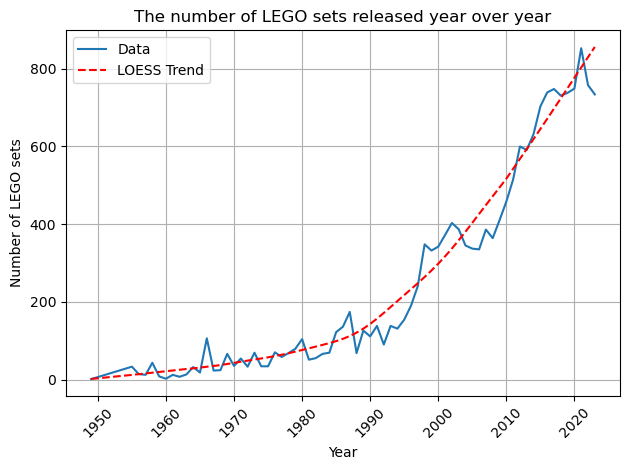

In [3739]:
# Number of sets released per year
sets_by_year = df.groupby("year").size().reset_index(name="number")

# Plot actual data
plt.plot(sets_by_year["year"][:-1], sets_by_year["number"][:-1], label="Data")

# Add a LOESS trend line
lowess = sm.nonparametric.lowess
loess_smoothed = lowess(sets_by_year["number"][:-1], sets_by_year["year"][:-1], frac=0.4)  # frac is the smoothing parameter
plt.plot(loess_smoothed[:, 0], loess_smoothed[:, 1], linestyle="--", label="LOESS Trend", color='r')

# Configure plot
plt.legend()
plt.title('The number of LEGO sets released year over year')
plt.xlabel("Year")
plt.ylabel("Number of LEGO sets")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig(plots_path / 'year_over_year_number_of_sets.pdf')
plt.show()

In [3740]:
#Sets released per year (table)
# The year 2024 is not included in the table because it has not yet ended.
sets_by_year_table = df.groupby("year").count()
sets_by_year_table["number"][:-1]

year
1949      1
1955     33
1956     14
1957     12
1958     43
       ... 
2019    738
2020    749
2021    853
2022    758
2023    734
Name: number, Length: 70, dtype: int64

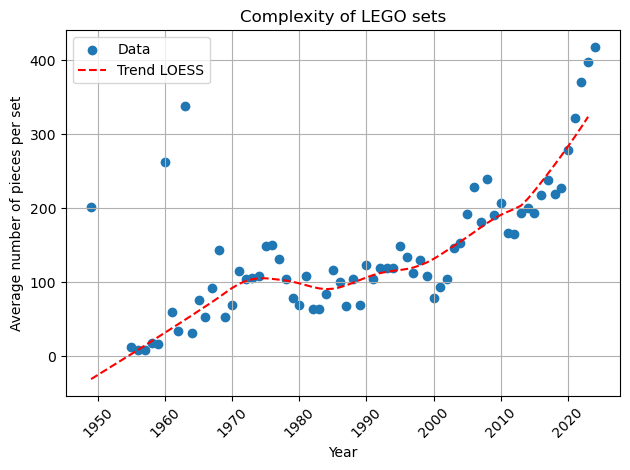

In [3741]:
# Complexity trend in LEGO sets per year
# Group the data by year and calculate the average number of parts per set
parts_per_set = df.groupby('year')['pieces'].mean()

# Create a scatter plot of the data
plt.scatter(parts_per_set.index, parts_per_set.values, label="Data")

# Add a LOESS trend line
lowess = sm.nonparametric.lowess
loess_smoothed = lowess(parts_per_set.values[:-1], parts_per_set.index[:-1], frac=0.3)  # frac is the smoothing parameter
plt.plot(loess_smoothed[:, 0], loess_smoothed[:, 1], 'r--', label="Trend LOESS")

# Add a legend to the plot
plt.legend()

# Show the plot
plt.title('Complexity of LEGO sets')
plt.xlabel('Year')
plt.ylabel('Average number of pieces per set')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(plots_path / 'year_over_year_complexity_of_sets.pdf')
plt.show()

#### HPR/APR

In [3742]:
# Filer database
df = df[(df['year'] >= 1980) & (df['year'] <= 2022)]
df = df[(df['pieces'] != 0)]
df = df[(df['retail'] != 0)]
df = df[(df['retired'] == True)]

# Reset index
df = df.reset_index(drop=True)

In [3743]:
# Create new columns (HPR, APR)
df['HPR'] = (df['value'] - df['retail']) / df['retail']
df['APR'] = ((df['HPR'] + 1) ** (1/(2024 - df['year']))) - 1

df

,number,name,theme,year,pieces,minifigs,availability,retired,released_date,retired_date,retail,value,HPR,APR
0,75144-1,Snowspeeder,Star Wars,2017,1703,2,Exclusive,True,2017-05-05 00:00:00,2019-01-15 00:00:00,199.99,330.40,0.652083,0.074354
1,10251-1,Brick Bank,Icons,2016,2380,6,RetailLimited,True,2016-01-02 00:00:00,2018-11-14 00:00:00,149.99,494.81,2.298953,0.160906
2,10252-1,Volkswagen Beetle,Icons,2016,1167,0,Exclusive,True,2016-08-01 00:00:00,2020-12-03 00:00:00,89.99,113.14,0.257251,0.029029
3,10253-1,Big Ben,Icons,2016,4163,0,Exclusive,True,2016-07-02 00:00:00,2018-11-25 00:00:00,219.99,327.12,0.486977,0.050843
4,10702-1,Creative Building Set,Classic,2016,583,0,Retail,True,2016-01-02 00:00:00,2017-11-24 00:00:00,24.99,30.14,0.206082,0.023699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10772,45809-1,City Shaper Challenge Kit,Education,2019,2238,1,Retail,True,2019-01-01 00:00:00,2021-01-01 00:00:00,175.99,338.05,0.920848,0.139459
10773,10659-2,Vehicle Suitcase,Juniors,2014,146,2,Retail,True,2014-01-01 00:00:00,2016-01-01 00:00:00,21.99,43.07,0.958618,0.069535
10774,9790-1,ROBOLAB Team Challenge Set,Education,1999,725,0,Retail,True,1999-01-01 00:00:00,2001-01-01 00:00:00,175.99,193.78,0.101085,0.003859
10775,2000443-1,Workshop Kit Freewheeler,Education,2015,82,1,RetailLimited,True,2015-01-01 00:00:00,2017-01-01 00:00:00,8.79,11.00,0.251422,0.025233


In [3744]:
# Average APR per year
APR_yearly = df.groupby("year").mean('APR')
print(APR_yearly['APR'].tail())

year
2018    0.085203
2019    0.077515
2020    0.082867
2021    0.090082
2022    0.104910
Name: APR, dtype: float64


In [3745]:
# Average APR of all sets
APR_mean = round(df['APR'].mean(), 6)
APR_mean

0.081781

In [3746]:
# Average APR per set theme
APR_by_themes = df.groupby("theme").mean('APR')
APR_by_themes = APR_by_themes.sort_values("APR", ascending=False)
APR_by_themes['APR']

theme
FORMA                        0.379361
BrickLink                    0.327697
Avatar The Last Airbender    0.183646
Mixels                       0.161662
BrickHeadz                   0.157204
                               ...   
DC Super Hero Girls          0.012488
LEGO Art                     0.012355
Trolls World Tour            0.003972
Horizon                     -0.062813
Avatar                      -0.097147
Name: APR, Length: 143, dtype: float64

In [3747]:
df['group'] = pd.cut(df['pieces'], bins=[0, 500, 1000, float('inf')], labels=['small', 'medium', 'big'])

# Calculate the average annual return for each size group
grouped = df.groupby('group')['APR'].mean()

round(grouped, 3)

/var/folders/1k/rsc6z_156_36hpxhr9fbzsch0000gn/T/ipykernel_57701/3202696324.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('group')['APR'].mean()


group
small     0.085
medium    0.064
big       0.059
Name: APR, dtype: float64

In [3748]:
# Highest APR values
df.sort_values("APR", ascending=False).head()

,number,name,theme,year,pieces,minifigs,availability,retired,released_date,retired_date,retail,value,HPR,APR,group
10382,6385891-1,Brick Lab,Promotional,2021,145,0,Exclusive,True,2021-01-01 00:00:00,2023-01-01 00:00:00,13.20,140.42,9.637879,1.199303,small
10617,71033-5,Kermit the Frog,Minifigure Series,2022,5,1,Retail,True,2022-05-01 00:00:00,2023-01-25 00:00:00,3.99,17.35,3.348371,1.085275,small
9266,853922-1,Creative Rings,Friends,2019,43,0,ExclusiveLEGOLAND,True,2019-01-01 00:00:00,2021-01-01 00:00:00,7.91,229.92,28.067004,0.961914,small
10355,10282-2,Adidas Originals Superstar X Footshop,Icons,2021,974,0,RetailLimited,True,2021-09-02 00:00:00,2023-09-02 00:00:00,89.99,632.67,6.030448,0.915701,medium
10390,43108-4,Dragon Guitarist,Vidiyo,2021,13,1,Retail,True,2021-11-01 00:00:00,2021-12-01 00:00:00,4.99,31.41,5.294589,0.846386,small


In [3749]:
# Lowest APR values
df.sort_values("APR", ascending=True).head()

,number,name,theme,year,pieces,minifigs,availability,retired,released_date,retired_date,retail,value,HPR,APR,group
10588,76947-1,Quetzalcoatlus Plane Ambush,Jurassic World,2022,306,3,Retail,True,2022-04-17 00:00:00,2023-12-01 00:00:00,49.99,32.91,-0.341668,-0.188624,small
10646,41716-1,Stephanie's Sailing Adventure,Friends,2022,304,3,Retail,True,2022-05-29 00:00:00,2024-02-01 00:00:00,44.99,30.83,-0.314737,-0.172194,small
10541,76206-1,Iron Man Figure,Marvel Super Heroes,2022,381,0,Retail,True,2022-01-02 00:00:00,2023-12-31 00:00:00,44.99,31.54,-0.298955,-0.162716,small
10735,76911-1,007 Aston Martin DB5,Speed Champions,2022,298,1,Retail,True,2022-07-26 00:00:00,2023-12-31 00:00:00,24.99,17.59,-0.296118,-0.161024,small
10764,76220-1,Batman versus Harley Quinn,DC Comics Super Heroes,2022,42,2,Retail,True,2022-09-01 00:00:00,2023-12-01 00:00:00,14.99,10.56,-0.295530,-0.160673,small


[*********************100%%**********************]  3 of 3 completed
/var/folders/1k/rsc6z_156_36hpxhr9fbzsch0000gn/T/ipykernel_57701/2813881306.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  other_instruments = other_instruments.resample('M').last()


,BTC-USD,DAX,SP500,Gold
Date,,,,
2023-08-31,25931.472656,15947.080078,4507.660156,1940.095
2023-09-30,26967.916016,15386.580078,4288.049805,1848.490
2023-10-31,34667.781250,14810.339844,4193.799805,1984.650
2023-11-30,37712.746094,16215.429688,4567.799805,2036.195
2023-12-31,42156.902344,16751.640625,4769.830078,2063.235


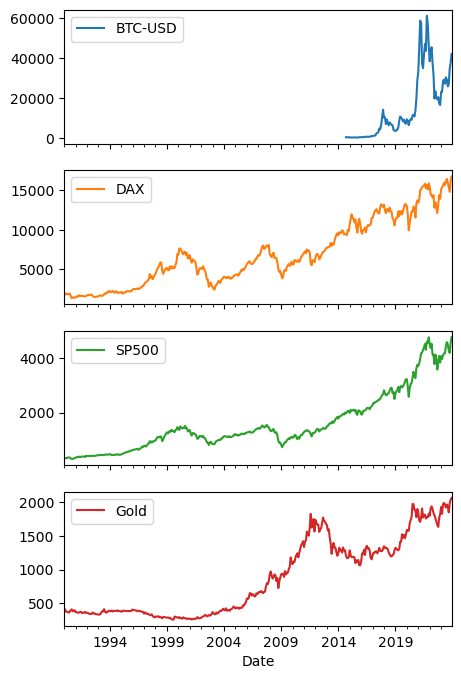

In [3750]:
yf.pdr_override()
other_instruments = pdr.get_data_yahoo(["^GSPC", "^GDAXI", "BTC-USD"], start="1990-01-01", end="2023-12-31")
other_instruments = other_instruments.resample('M').last()
other_instruments = other_instruments['Close']
other_instruments = other_instruments.rename(columns={'^GSPC': 'SP500', 'WIG20.WA': 'WIG20', '^GDAXI': 'DAX'})
gold_historical_data = pd.read_csv(csv_path / 'xauusd.csv')
other_instruments = other_instruments.reset_index()
other_instruments = other_instruments.join(gold_historical_data['Close'])
other_instruments = other_instruments.rename(columns={'Close': 'Gold'})

#Set 'Date' as index
other_instruments.set_index("Date", inplace=True)
other_instruments.plot(figsize=(5,8), subplots=True)
plt.savefig(plots_path / 'long_time_series_all.pdf')

other_instruments.tail()

In [3751]:
HPR_SP500 = (((other_instruments['SP500'].iloc[-1] - other_instruments['SP500'].iloc[0]) / other_instruments['SP500'].iloc[0]))
APR_SP500 = round(((HPR_SP500 + 1) ** (1/34)) - 1, 6)

HPR_DAX = (((other_instruments['DAX'].iloc[-1] - other_instruments['DAX'].iloc[0]) / other_instruments['DAX'].iloc[0]))
APR_DAX = round(((HPR_DAX + 1) ** (1/34)) - 1, 6)

HPR_Gold = (((other_instruments['Gold'].iloc[-1] - other_instruments['Gold'].iloc[0]) / other_instruments['Gold'].iloc[0]))
APR_Gold = round(((HPR_Gold + 1) ** (1/34)) - 1, 6)

HPR_BTC = ((other_instruments['BTC-USD'].iloc[-1] - other_instruments['BTC-USD'].iloc[300]) / other_instruments['BTC-USD'].iloc[300])
APR_BTC = round(((HPR_BTC + 1) ** (1/9)) - 1, 6)

APR_lego_1990 = round(df.loc[df['year'].isin(np.arange(1990, 2025, 1)), 'APR'].mean(), 6)

In [3752]:
print(f'APR for SP500: {APR_SP500}')
print(f'APR for DAX: {APR_DAX}')
print(f'APR for Gold: {APR_Gold}')
print(f'APR for BTC: {APR_BTC}')
print(f'APR for LEGO: {APR_lego_1990}')

APR for SP500: 0.081815
APR for DAX: 0.067441
APR for Gold: 0.048092
APR for BTC: 0.795414
APR for LEGO: 0.082783


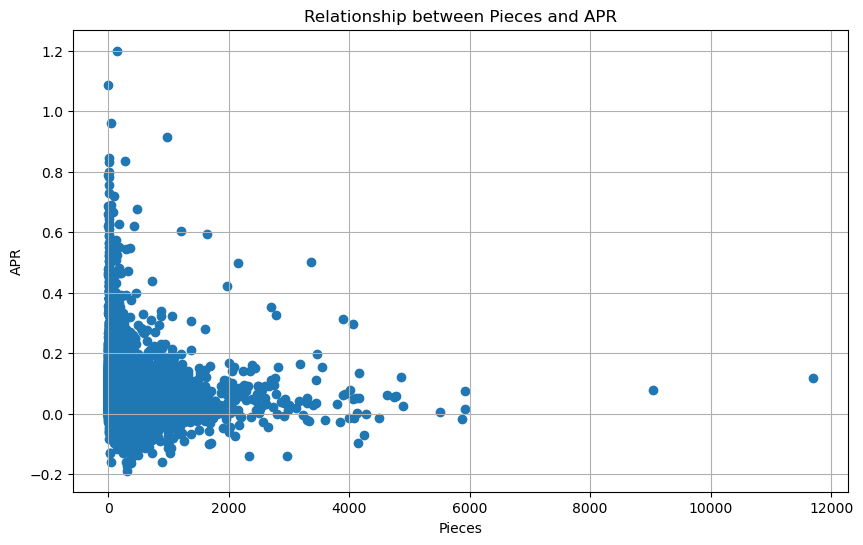

In [3753]:
plt.figure(figsize=(10, 6))
plt.scatter(df['pieces'], df['APR'])
plt.title('Relationship between Pieces and APR')
plt.xlabel('Pieces')
plt.ylabel('APR')
plt.grid(True)
plt.show()

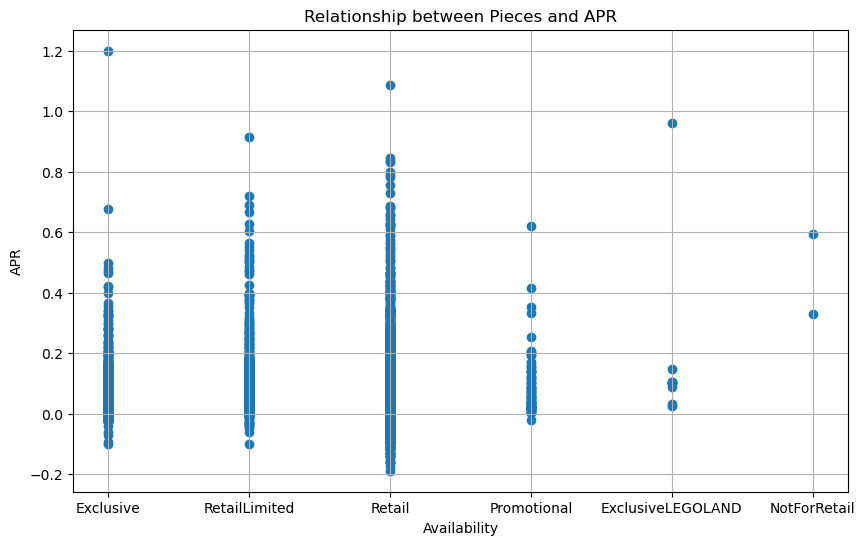

In [3754]:
plt.figure(figsize=(10, 6))
plt.scatter(df['availability'], df['APR'])
plt.title('Relationship between Pieces and APR')
plt.xlabel('Availability')
plt.ylabel('APR')
plt.grid(True)
plt.show()

In [3755]:
# Transforming columns with dates into date format
df['released_date'] = pd.to_datetime(df['released_date'])
df['retired_date'] = pd.to_datetime(df['retired_date'])

# Extracting the month from release and retirement dates
df['released_month'] = df['released_date'].dt.month
df['retired_month'] = df['retired_date'].dt.month

# Grouping data by release and retirement months
release_monthly = df['released_month'].value_counts().sort_index()
retire_monthly = df['retired_month'].value_counts().sort_index()

In [3756]:
# Calculating the time on the market in days
df['time_on_market'] = (df['retired_date'] - df['released_date']).dt.days

# Calculating the average time on the market
average_time_on_market = df['time_on_market'].mean()

average_time_on_market, df['time_on_market'].min(), df['time_on_market'].max()

(594.6510160527048, 0, 4729)

In [3757]:
df.head()

,number,name,theme,year,pieces,minifigs,availability,retired,released_date,retired_date,retail,value,HPR,APR,group,released_month,retired_month,time_on_market
0,75144-1,Snowspeeder,Star Wars,2017,1703,2,Exclusive,True,2017-05-05,2019-01-15,199.99,330.40,0.652083,0.074354,big,5,1,620
1,10251-1,Brick Bank,Icons,2016,2380,6,RetailLimited,True,2016-01-02,2018-11-14,149.99,494.81,2.298953,0.160906,big,1,11,1047
2,10252-1,Volkswagen Beetle,Icons,2016,1167,0,Exclusive,True,2016-08-01,2020-12-03,89.99,113.14,0.257251,0.029029,big,8,12,1585
3,10253-1,Big Ben,Icons,2016,4163,0,Exclusive,True,2016-07-02,2018-11-25,219.99,327.12,0.486977,0.050843,big,7,11,876
4,10702-1,Creative Building Set,Classic,2016,583,0,Retail,True,2016-01-02,2017-11-24,24.99,30.14,0.206082,0.023699,medium,1,11,692


In [3758]:
timeseries.head()

,set_num,name_sets,year,theme_id,num_parts,name_themes,retail_price,sty.21,lut.21,mar.21,...,mar.23,kwi.23,maj.23,cze.23,lip.23,sie.23,wrz.23,paź.23,lis.23,gru.23
0,5289-1,Toggle Joints & Connectors,1996,453,64,Technic,3.95,9.30,8.87,9.34,...,9.31,8.08,7.91,6.83,8.43,7.91,6.32,8.13,7.91,7.01
1,7121-1,Naboo Swamp,1999,158,82,Star Wars,8.79,60.92,56.85,56.33,...,72.70,58.29,71.98,91.15,79.82,70.74,85.92,91.52,71.70,66.79
2,7111-1,Droid Fighter,1999,158,62,Star Wars,5.27,28.77,27.33,32.72,...,46.50,54.41,42.72,48.57,42.17,56.06,47.54,41.01,50.64,39.90
3,7171-1,Mos Espa Podrace,1999,158,907,Star Wars,79.19,275.43,327.97,367.35,...,333.09,304.65,323.50,339.89,334.51,433.46,367.34,431.05,375.69,349.02
4,7104-1,Desert Skiff,2000,158,55,Star Wars,5.27,66.64,46.98,62.45,...,64.62,62.74,68.10,77.60,66.18,64.22,79.69,74.27,65.38,59.95


In [3759]:
timeseries = timeseries.dropna(subset=['retail_price'])
timeseries = timeseries.reset_index(drop=True)
timeseries = timeseries.sort_values(by='year')
timeseries = timeseries.replace(',', '.')

In [3760]:
average_values = timeseries.iloc[:, 8:].apply(lambda x: x.mean(), axis=0)
average_values_list = average_values.tolist()

average_values_rounded = [round(x, 6) for x in average_values_list]

average_values_rounded_series = pd.Series(average_values_rounded, name='average_values_rounded')
average_values_rounded_series.name = 'average_values_rounded'
timeseries['average_values_rounded'] = average_values_rounded_series

LEGO_basket = pd.DataFrame(average_values_rounded_series)

[**********************50%%                      ]  2 of 4 completed

[*********************100%%**********************]  4 of 4 completed
/var/folders/1k/rsc6z_156_36hpxhr9fbzsch0000gn/T/ipykernel_57701/1777181478.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  other_instruments = other_instruments.resample('M').last()


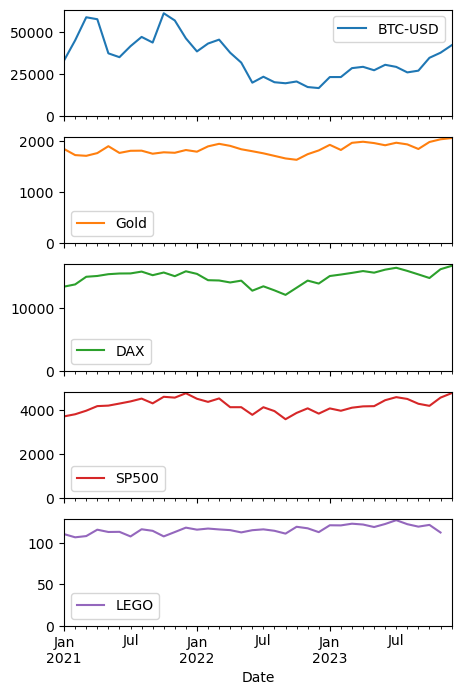

In [3761]:
yf.pdr_override()
other_instruments = pdr.get_data_yahoo(["GC=F", "^GSPC", "^GDAXI", "BTC-USD"], start="2021-01-01", end="2023-12-31")
other_instruments = other_instruments.resample('M').last()
other_instruments = other_instruments['Close']
other_instruments = other_instruments.reset_index()

# Merge LEGO_basket and other_investments
all_instruments = pd.concat([other_instruments, LEGO_basket], axis=1)
all_instruments= all_instruments.rename(columns={'GC=F': 'Gold', '^GSPC': 'SP500', 'WIG20.WA': 'WIG20', '^GDAXI': 'DAX','average_values_rounded': 'LEGO'})

# Set 'Date' as index
all_instruments.set_index("Date", inplace=True)
all_instruments.plot(figsize=(5,8), subplots=True)

# Set the minimum value on the y-axis to 0 for all subplots
for ax in plt.gcf().get_axes():
    ax.set_ylim(bottom=0)

plt.savefig(plots_path / 'time_series_from_zero_all.pdf')

plt.show()

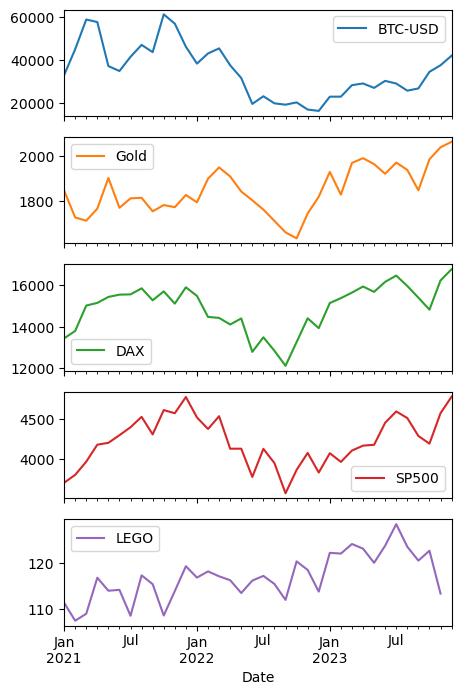

In [3762]:
all_instruments.plot(figsize=(5,8), subplots=True)
plt.savefig(plots_path / 'time_series_all.pdf')

In [3763]:
all_instruments.tail()

,BTC-USD,Gold,DAX,SP500,LEGO
Date,,,,,
2023-08-31,25931.472656,1938.199951,15947.080078,4507.660156,123.486562
2023-09-30,26967.916016,1848.099976,15386.580078,4288.049805,120.485208
2023-10-31,34667.781250,1985.199951,14810.339844,4193.799805,122.621667
2023-11-30,37712.746094,2038.099976,16215.429688,4567.799805,113.352917
2023-12-31,42156.902344,2062.399902,16751.640625,4769.830078,NaN


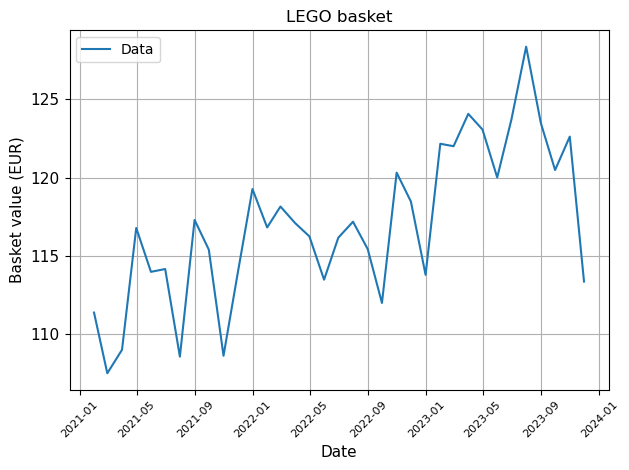

In [3764]:
# Extract x and y values from the DataFrame
x = all_instruments.index.to_numpy()
y = all_instruments['LEGO'].to_numpy()

# Plot the original data
plt.plot(x, y, label='Data')

# Show the plot without any trend line
plt.title('LEGO basket')
plt.xticks(fontsize=8)
plt.yticks(fontsize=11)
plt.ylabel('Basket value (EUR)', fontsize=11)
plt.xlabel('Date', fontsize=11)
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig(plots_path / 'lego_basket.pdf')
plt.show()

#### Volatility:

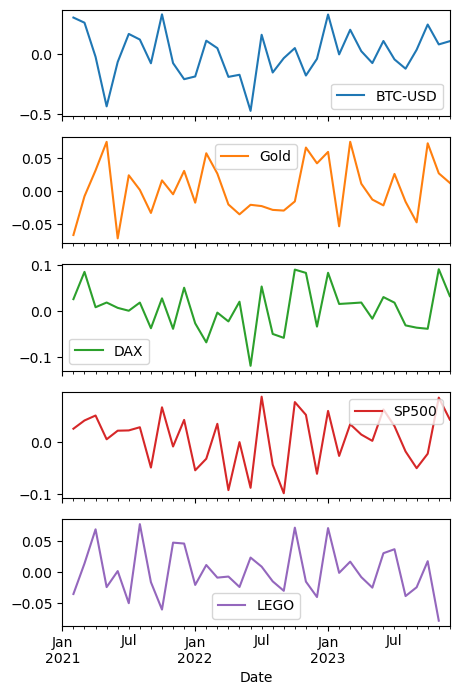

In [3765]:
# PCT change
instruments = ['BTC-USD', 'Gold', 'DAX', 'SP500', 'LEGO']
price_change = np.log(all_instruments[instruments] / all_instruments[instruments].shift(1))
price_change.plot(figsize=(5,8), subplots=True)
plt.savefig(plots_path /'price_change.pdf')

In [3766]:
# Calculate std of returns of each column
std_dev = price_change.std()
std_dev

BTC-USD    0.193572
Gold       0.040213
DAX        0.048672
SP500      0.051335
LEGO       0.039172
dtype: float64

In [3767]:
# Coefficient of Variation
COV = (all_instruments.std()/all_instruments.mean())*100
COV

BTC-USD    35.462637
Gold        5.724456
DAX         7.533373
SP500       7.115718
LEGO        4.274770
dtype: float64

In [3768]:
def drawdown(price_change):
    price_change.fillna(0.0, inplace=True)
    cumulative = (price_change + 1).cumprod()
    running_max = np.maximum.accumulate(cumulative)

    return (cumulative - running_max) / running_max

/opt/anaconda3/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:1794: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(None, 0)


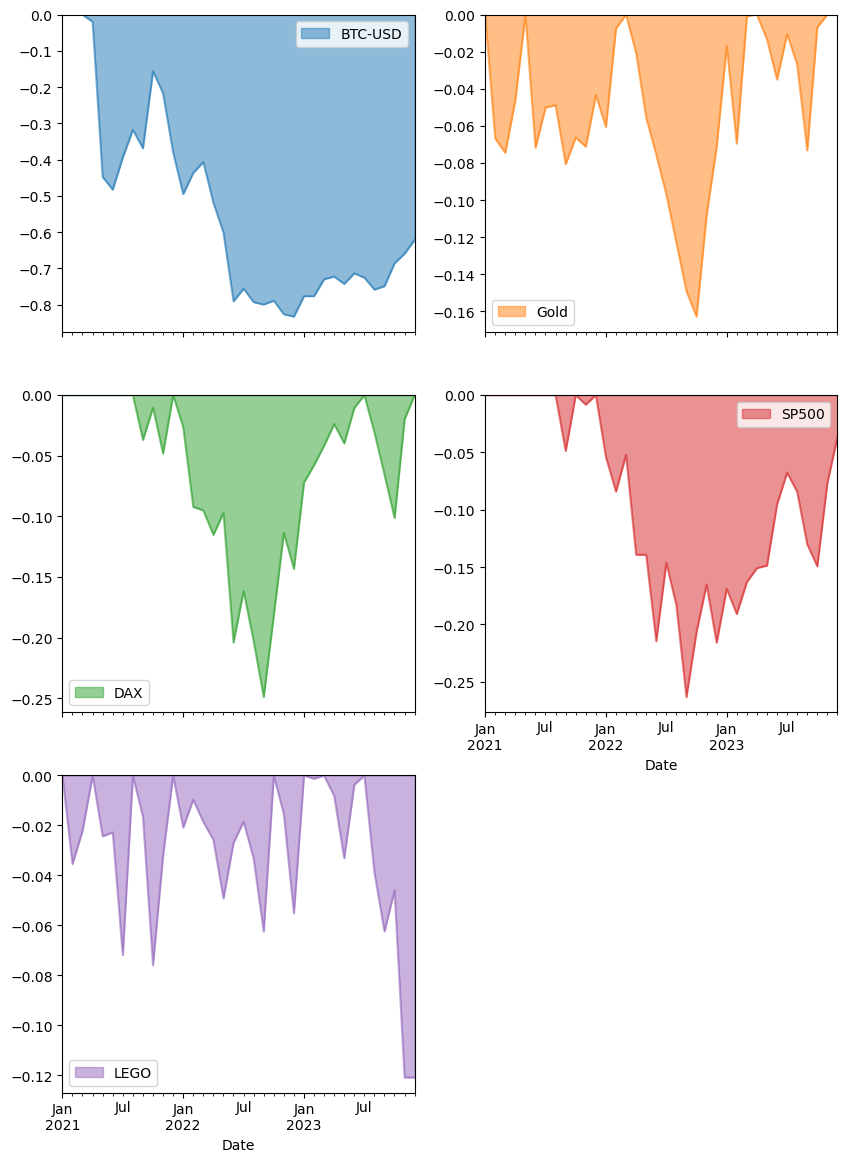

In [3769]:
drawdown(price_change).plot(kind="area", alpha=0.5, subplots=True, layout=(3, 2), figsize=(10,14))
plt.savefig(plots_path / 'max_drawdown.pdf')

In [3770]:
assets = ['BTC-USD', 'Gold', 'DAX', 'SP500', 'LEGO']
for asset in assets:
    md = np.min(drawdown(price_change[asset]))
    print(f'Maximum drawdown for {asset} was {round(np.min(drawdown(price_change[asset])), 2)}')

Maximum drawdown for BTC-USD was -0.83
Maximum drawdown for Gold was -0.16
Maximum drawdown for DAX was -0.25
Maximum drawdown for SP500 was -0.26
Maximum drawdown for LEGO was -0.12


#### Correlation matrix:

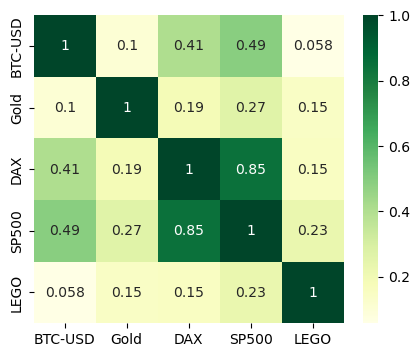

In [3771]:
# Correlation (price_change)
corr_matrix_price_change = price_change.corr()

plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix_price_change, annot=True, cmap='YlGn')
plt.savefig(plots_path / 'correlation_price_change.pdf')

plt.show()

#### Liquidity:

In [3772]:
# Read csv file
sales_mean =float(liquidity['num_of_sales_in_2023'].dropna().mean())
sales_mean

118.48958333333333

In [3773]:
# Average time needed to sell a set
time_needed = 365 / sales_mean
print(f'Average time needed to sell a set: {round(time_needed, 2)}')

Average time needed to sell a set: 3.08
